In [ ]:
# Constants
MAX_NO_ROWS = 1000000
FEATURE = 'ft_kettle'
SEQ_PER_BATCH = 1024
SEQ_LEN = 32
N_STRIDES = 1
NORM_TYPE = 'mean'
LEARNING_RATE = 1e-3
CLIP_VALUE = 10.
ALGO = 'cnn'
CHECKPOINT_PATH = f"{ALGO}_training_{FEATURE}/cp.ckpt"

In [ ]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow import keras

%matplotlib inline
print(tf.version.VERSION)

2.11.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/Dissertation

/content/drive/My Drive/Colab Notebooks/Dissertation


In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from lib.chunk_reader import read_labels, get_merged_chunks, get_dates
from lib.plotting import plot_ft_days, plot_model_history, plot_prediction_windows
from lib.analysis import print_heads_tails

In [ ]:
labels = read_labels(2)
for house in range(2,3):
    print('House {}: '.format(house), labels[house], '\n')

House 2:  ['mains_active', 'mains_apparent', 'mains_rms', 'aggregate_apparent', 'ft_laptop', 'ft_monitor', 'ft_speakers', 'ft_server', 'ft_router', 'ft_server_hdd', 'ft_kettle', 'ft_rice_cooker', 'ft_running_machine', 'ft_laptop2', 'ft_washing_machine', 'ft_dish_washer', 'ft_fridge', 'ft_microwave', 'ft_modem', 'aggregate_active', 'unix_time'] 



In [ ]:
ref_chunk_df = get_merged_chunks(2, 1)
print('Original DF shape', ref_chunk_df.shape)
print('---')
ref_chunk_df = ref_chunk_df[0:MAX_NO_ROWS]

reading house 2; chunk 1
reading file data/ukdale-parsed-chunks/house_2/chunk_1.dat; for house 2 and chunk 1
read house 2; chunk 1; df.shape is (2049466, 22)
Original DF shape (2049466, 22)
---


In [ ]:
dates = {}
# for house in range(1,2):
dates[2] = get_dates(ref_chunk_df, 2)

House 2 data contain 71 days from 2013-05-20 to 2013-07-29.
['2013-05-20', '2013-05-21', '2013-05-22', '2013-05-23', '2013-05-24', '2013-05-25', '2013-05-26', '2013-05-27', '2013-05-28', '2013-05-29', '2013-05-30', '2013-05-31', '2013-06-01', '2013-06-02', '2013-06-03', '2013-06-04', '2013-06-05', '2013-06-06', '2013-06-07', '2013-06-08', '2013-06-09', '2013-06-10', '2013-06-11', '2013-06-12', '2013-06-13', '2013-06-14', '2013-06-15', '2013-06-16', '2013-06-17', '2013-06-18', '2013-06-19', '2013-06-20', '2013-06-21', '2013-06-22', '2013-06-23', '2013-06-24', '2013-06-25', '2013-06-26', '2013-06-27', '2013-06-28', '2013-06-29', '2013-06-30', '2013-07-01', '2013-07-02', '2013-07-03', '2013-07-04', '2013-07-05', '2013-07-06', '2013-07-07', '2013-07-08', '2013-07-09', '2013-07-10', '2013-07-11', '2013-07-12', '2013-07-13', '2013-07-14', '2013-07-15', '2013-07-16', '2013-07-17', '2013-07-18', '2013-07-19', '2013-07-20', '2013-07-21', '2013-07-22', '2013-07-23', '2013-07-24', '2013-07-25', '

In [ ]:
# Constants 2
rows_per_day = ref_chunk_df.loc[:dates[2][2]].shape[0]

(44703,)
(14901, 3)


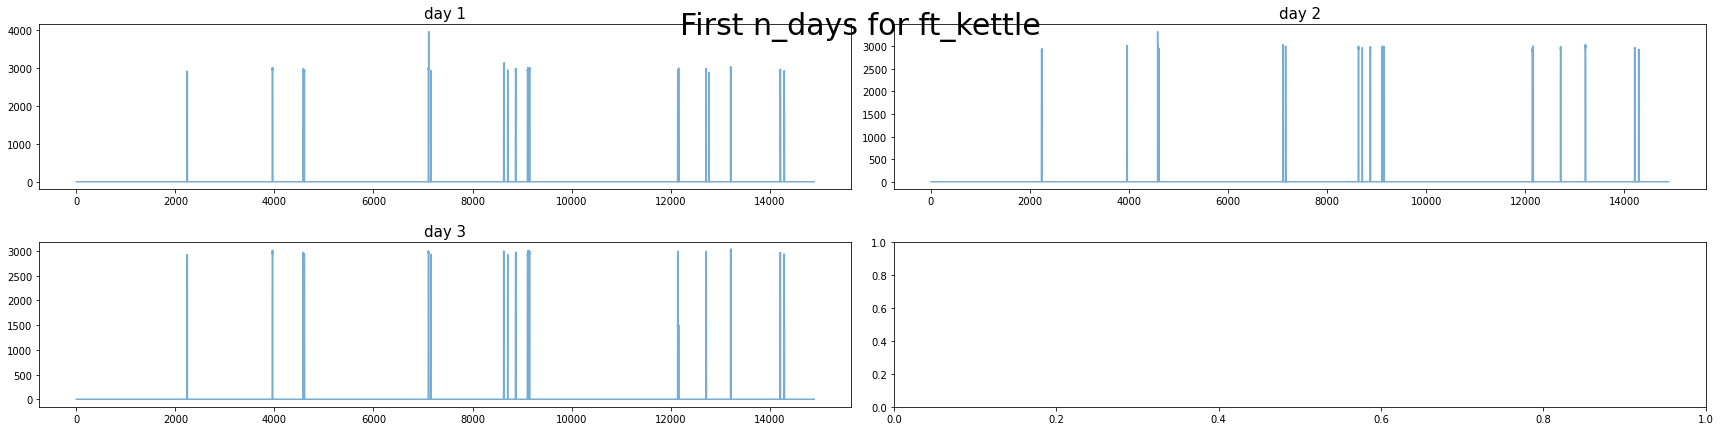

In [ ]:
plot_ft_days(ref_chunk_df, dates, 2, FEATURE, 3)

In [ ]:
from algos.processing import split_df_by_dates
from algos.cnn import create_model, train, predict
from algos.norm import get_ref_norm, denormalize, normalize

In [ ]:
# Separate house 1 data into train, validation and test data
df_train, df_val, df_test  =  split_df_by_dates(ref_chunk_df, dates=dates, house=2)

df_train.shape:  (519903, 22)
df_val.shape:  (316800, 22)
df_test.shape:  (192097, 22)


In [ ]:
ref_norm = get_ref_norm(df_train, NORM_TYPE)

ref_mean: 293.7677001953125; ref_max: 6003.89013671875; ref_std: 482.95953369140625
norm_type: mean; ref_norm 293.7677001953125


In [ ]:
model = create_model(seq_len=SEQ_LEN, learning_rate=LEARNING_RATE, clipvalue=CLIP_VALUE)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 32, 30)            330       
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 30)            7230      
                                                                 
 conv1d_2 (Conv1D)           (None, 32, 40)            7240      
                                                                 
 conv1d_3 (Conv1D)           (None, 32, 50)            10050     
                                                                 
 conv1d_4 (Conv1D)           (None, 32, 50)            12550     
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 1024)              1

In [ ]:
# !!!!!!!Counter!!!!!!! 
# Manually update for every new loaded training
# Run Counter = 0

# Load and or Train
model.load_weights(CHECKPOINT_PATH)

In [ ]:
# Predict from test split
y_test, y_pred = predict(model, feature=FEATURE, df_test=df_test, ref_norm=ref_norm, seq_len=SEQ_LEN, seq_per_batch=SEQ_PER_BATCH)

x_test.shape, y_test.shape
(192097, 1) (192097, 1)
self.data_len 192097
seq_len 32
n_sequences 192065
x.shape, y.shape (192065, 32, 1) (192065,)
seq_index 0
seq_index 160000
188/188 [==============================] - 8s 4ms/step
y_test.shape, y_pred.shape
(192065,) (192065, 1)
y_test.shape, y_pred.shape
(192065,) (192065,)
Normalized: y_test.mean, y_pred.mean
0.06581845 0.07126667
Denormalized: y_test.mean, y_pred.mean
19.335337 20.980612


In [ ]:
# plot_prediction_windows(FEATURE, y_test_denorm, y_pred_denorm)

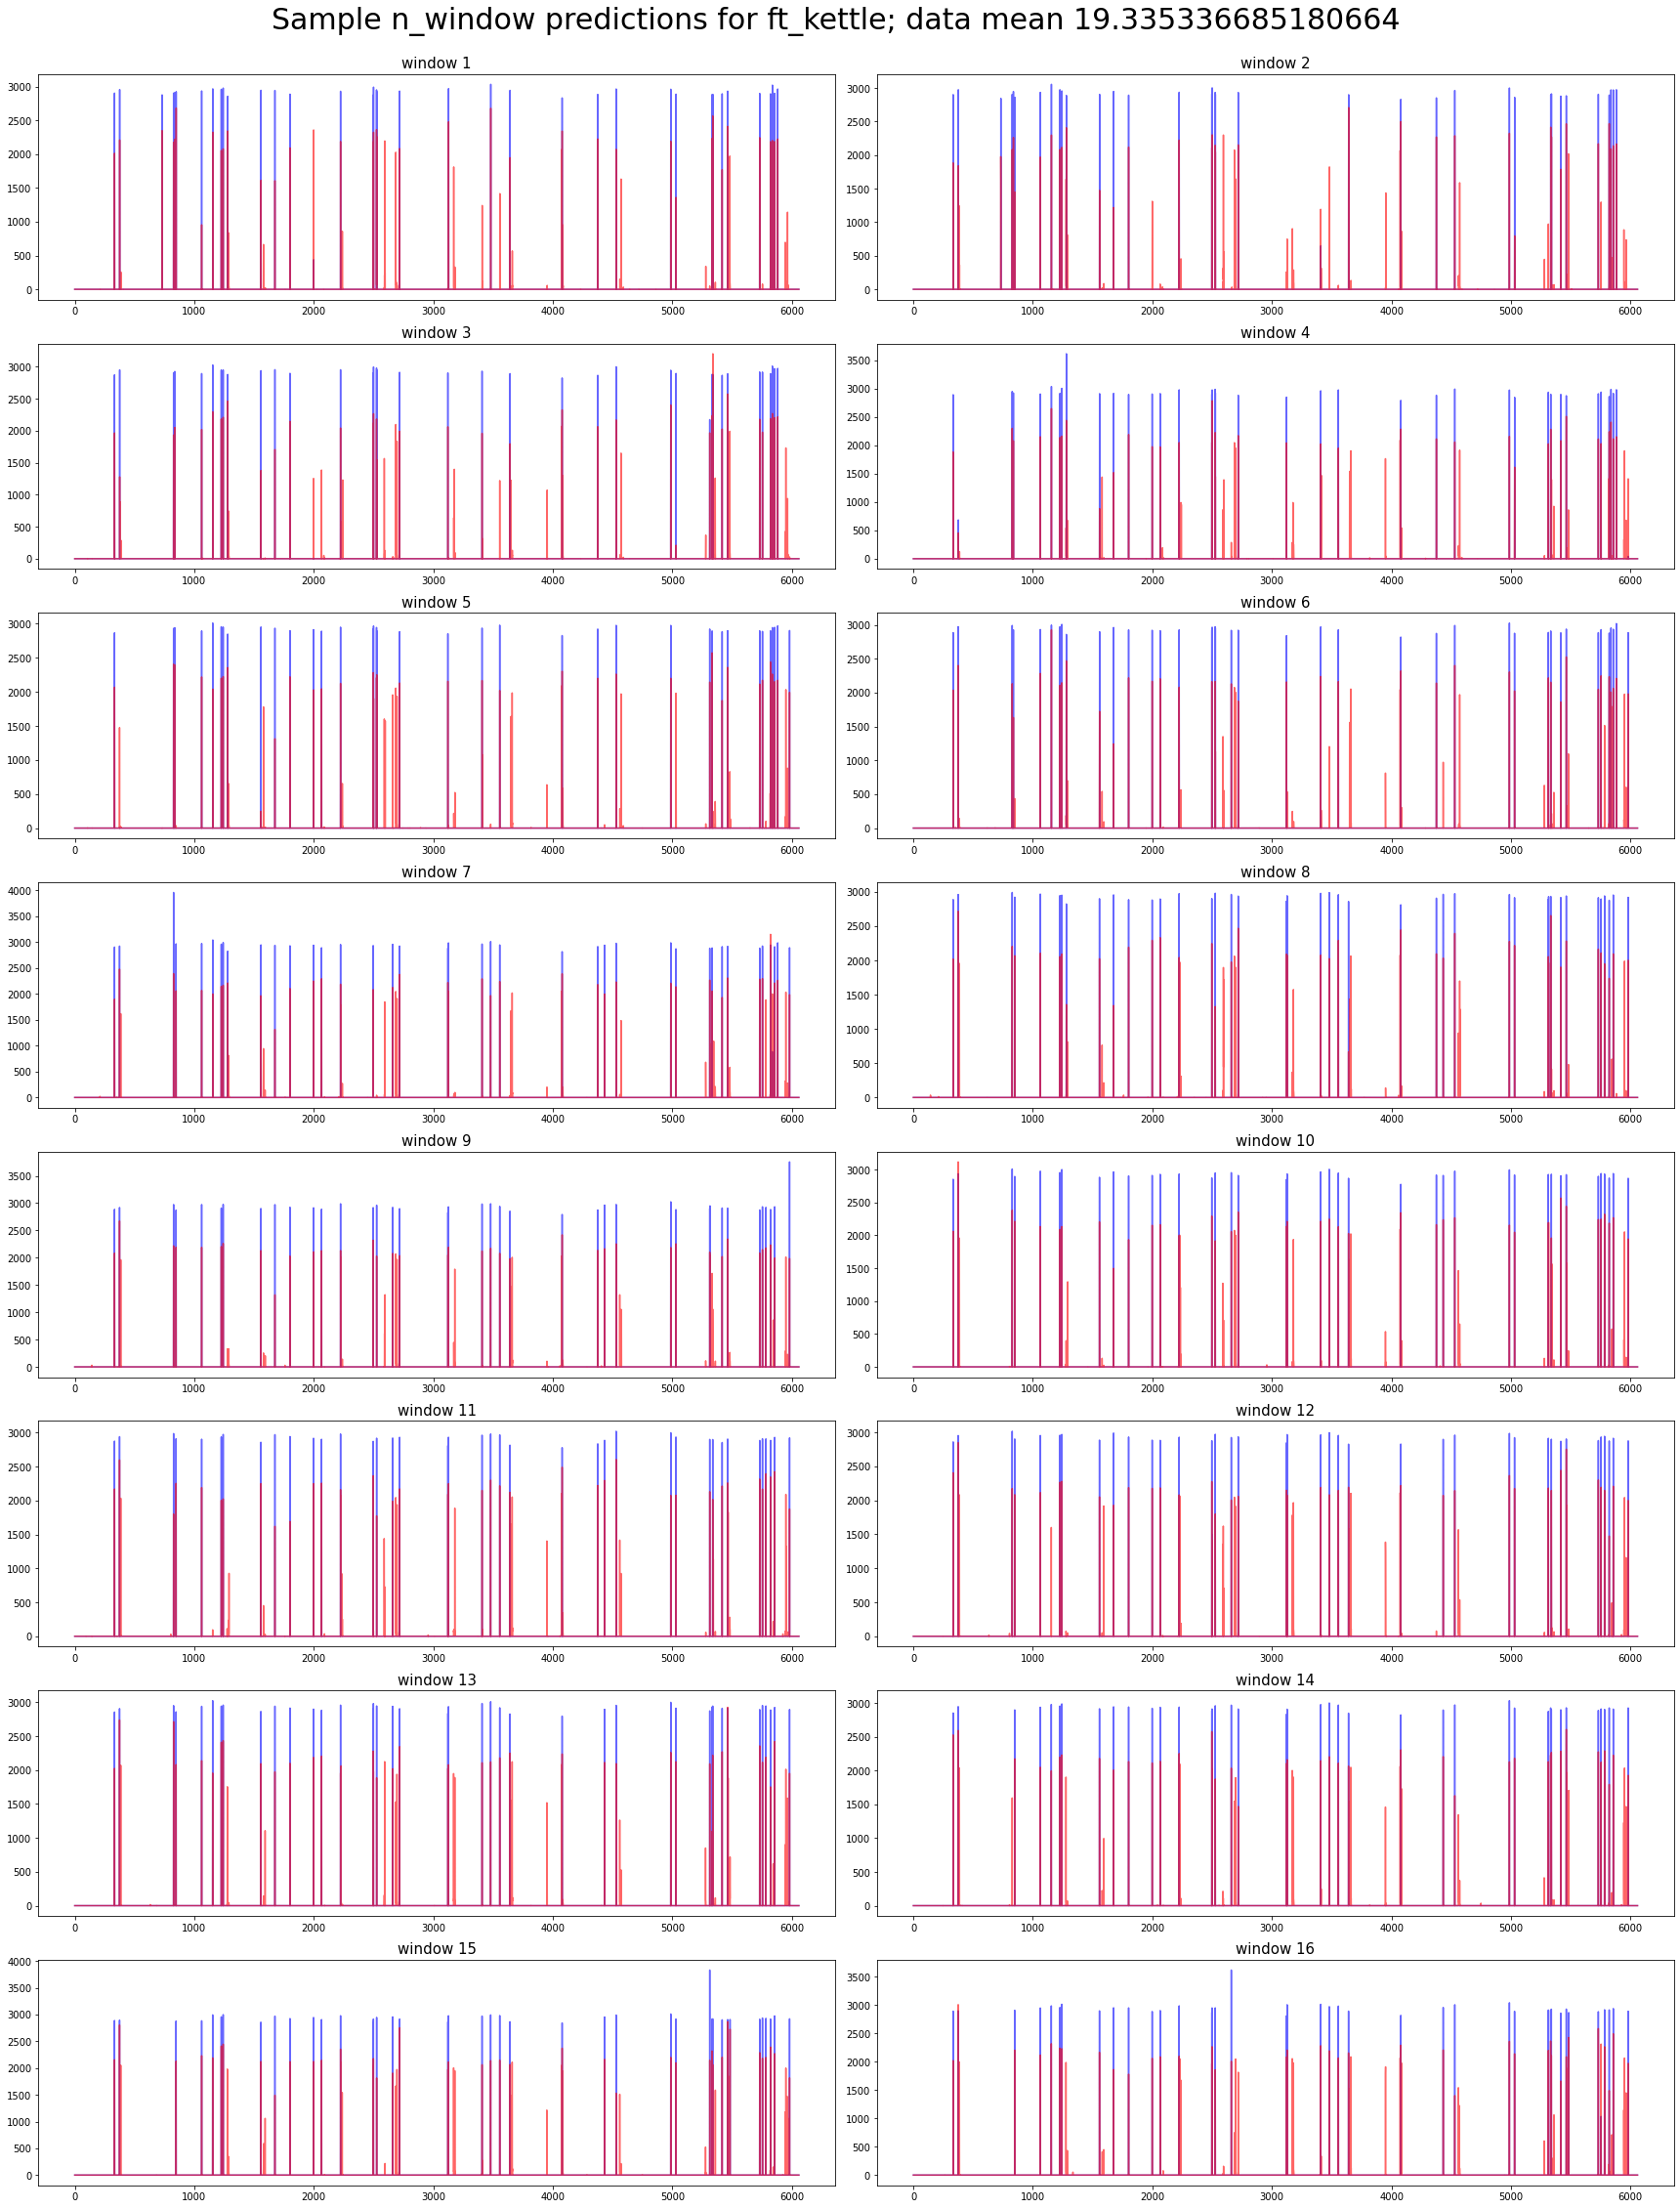

In [ ]:
n_samples = int(rows_per_day * 0.2)
plot_prediction_windows(FEATURE, y_test, y_pred, use_active=False, n_samples=n_samples)

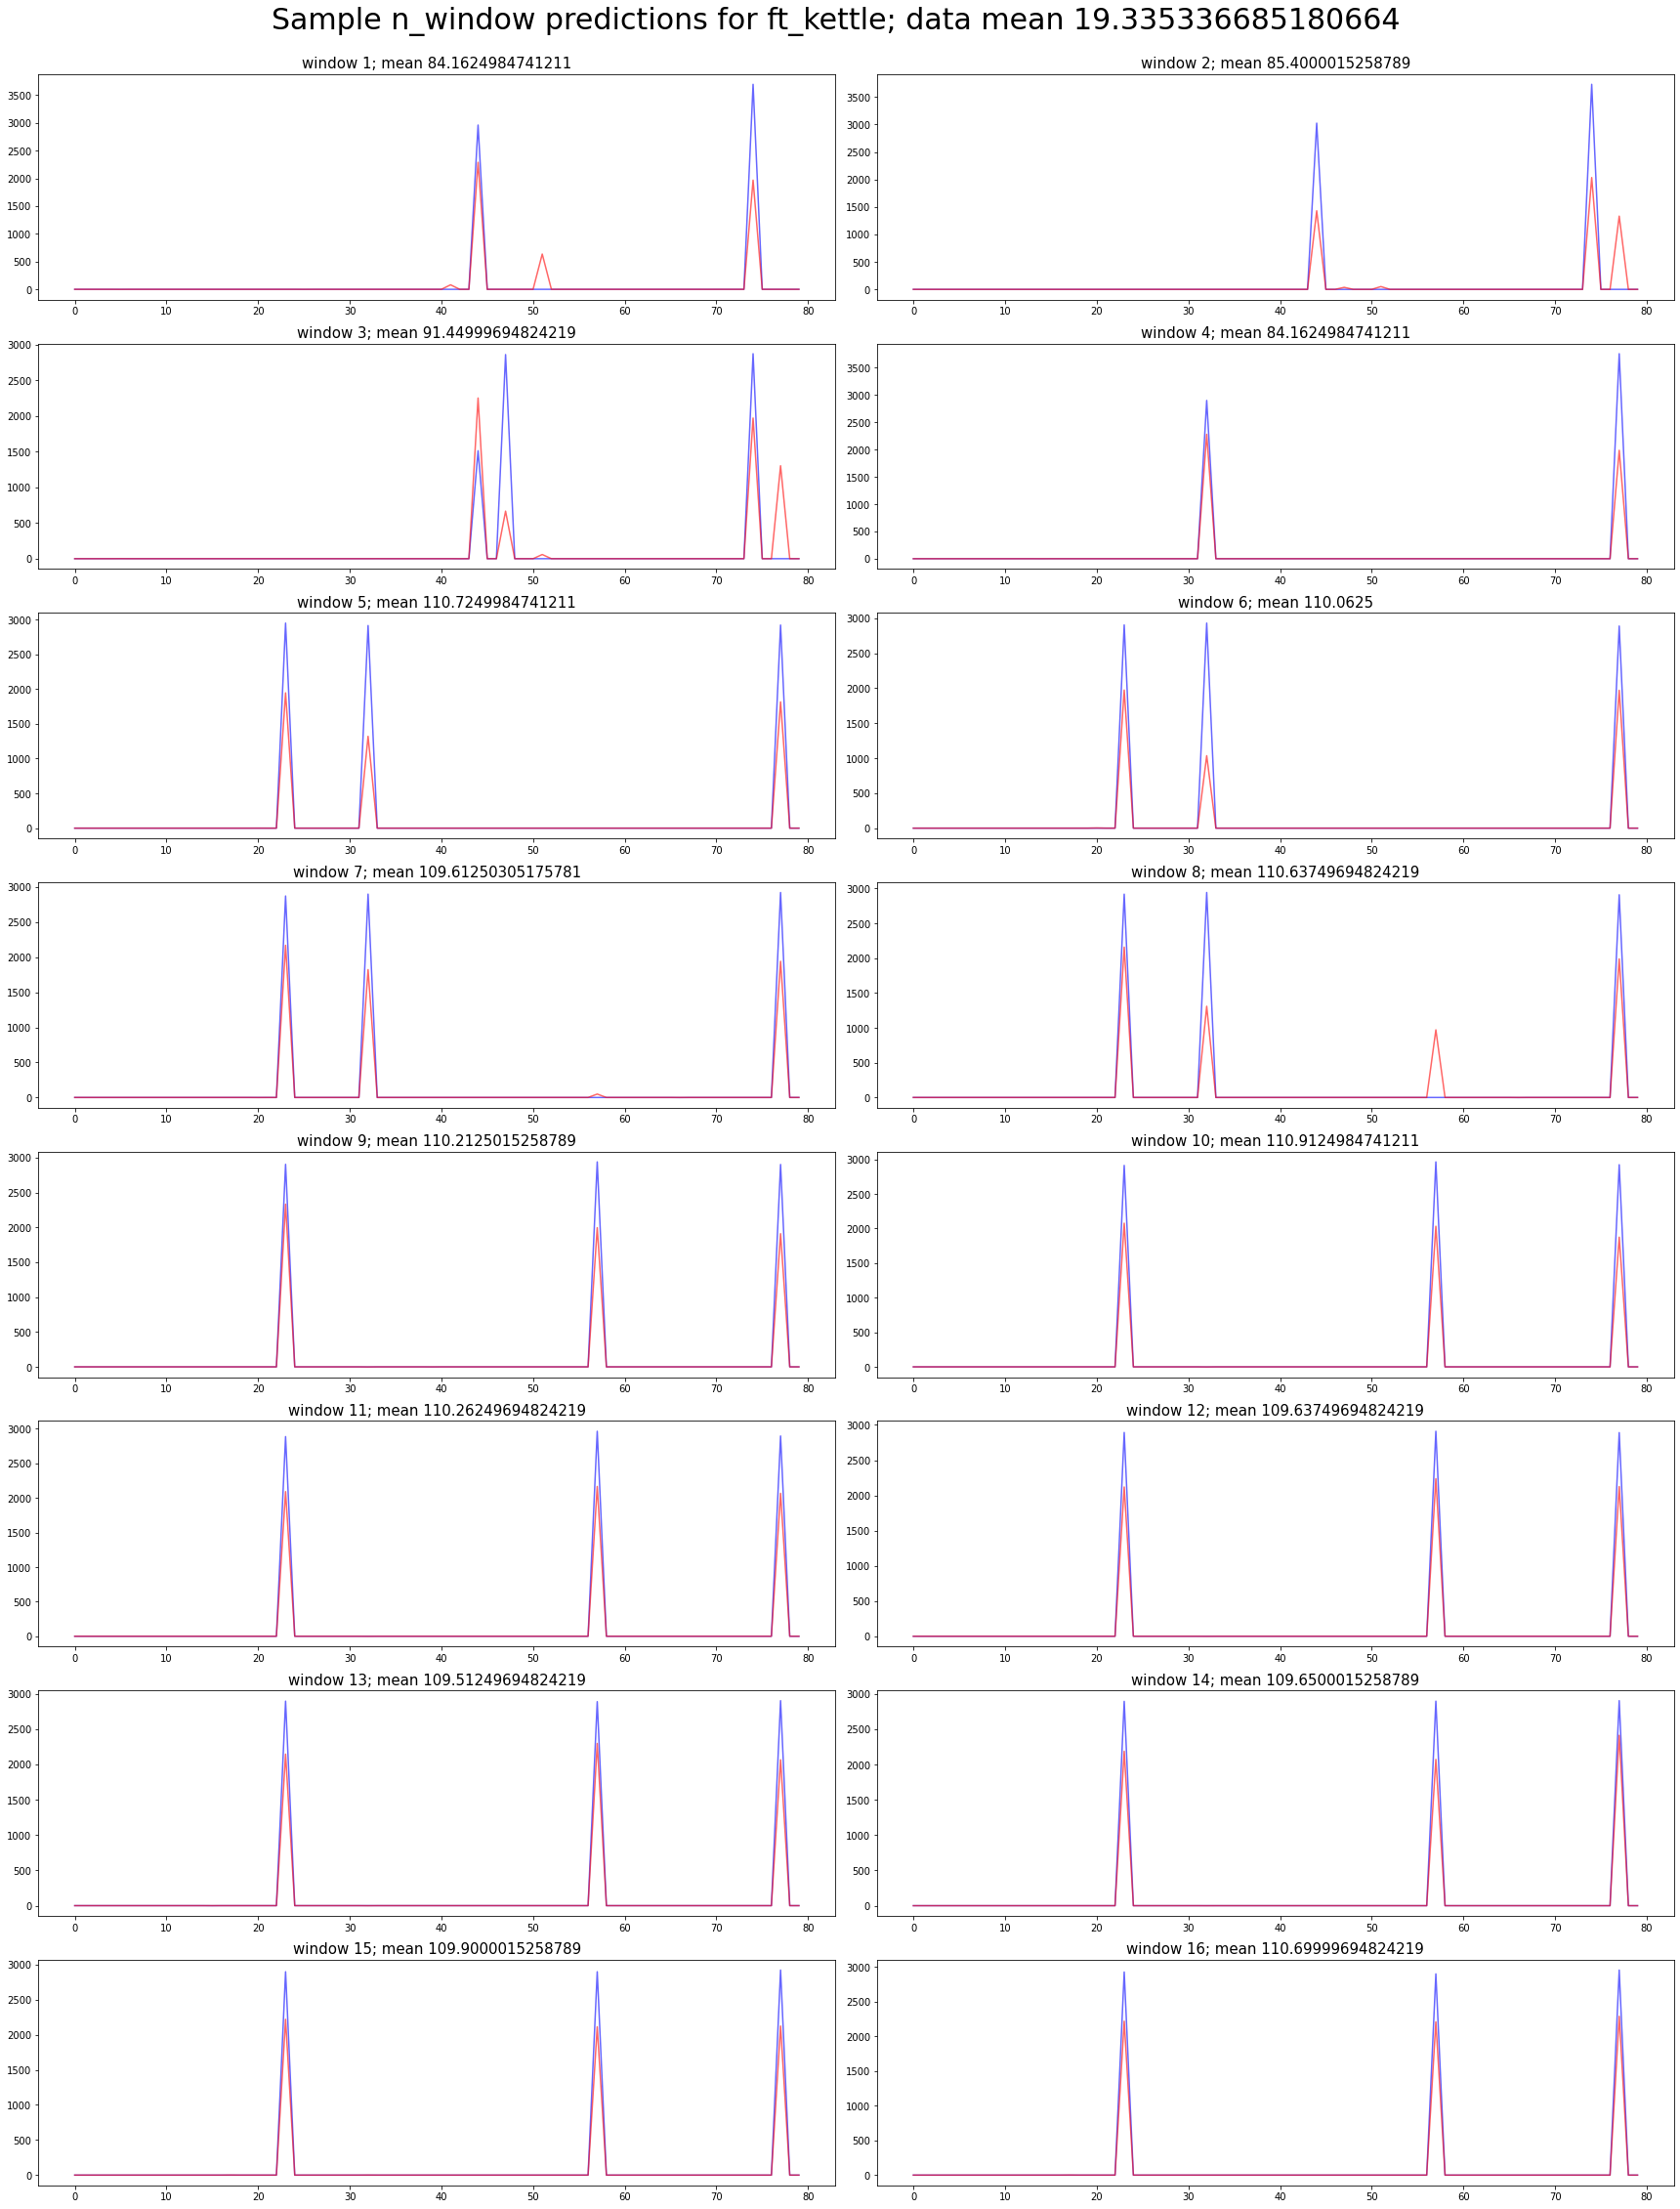

In [ ]:
n_samples = 80
plot_prediction_windows(FEATURE, y_test, y_pred, use_active=True, active_factor=4, n_samples=n_samples)

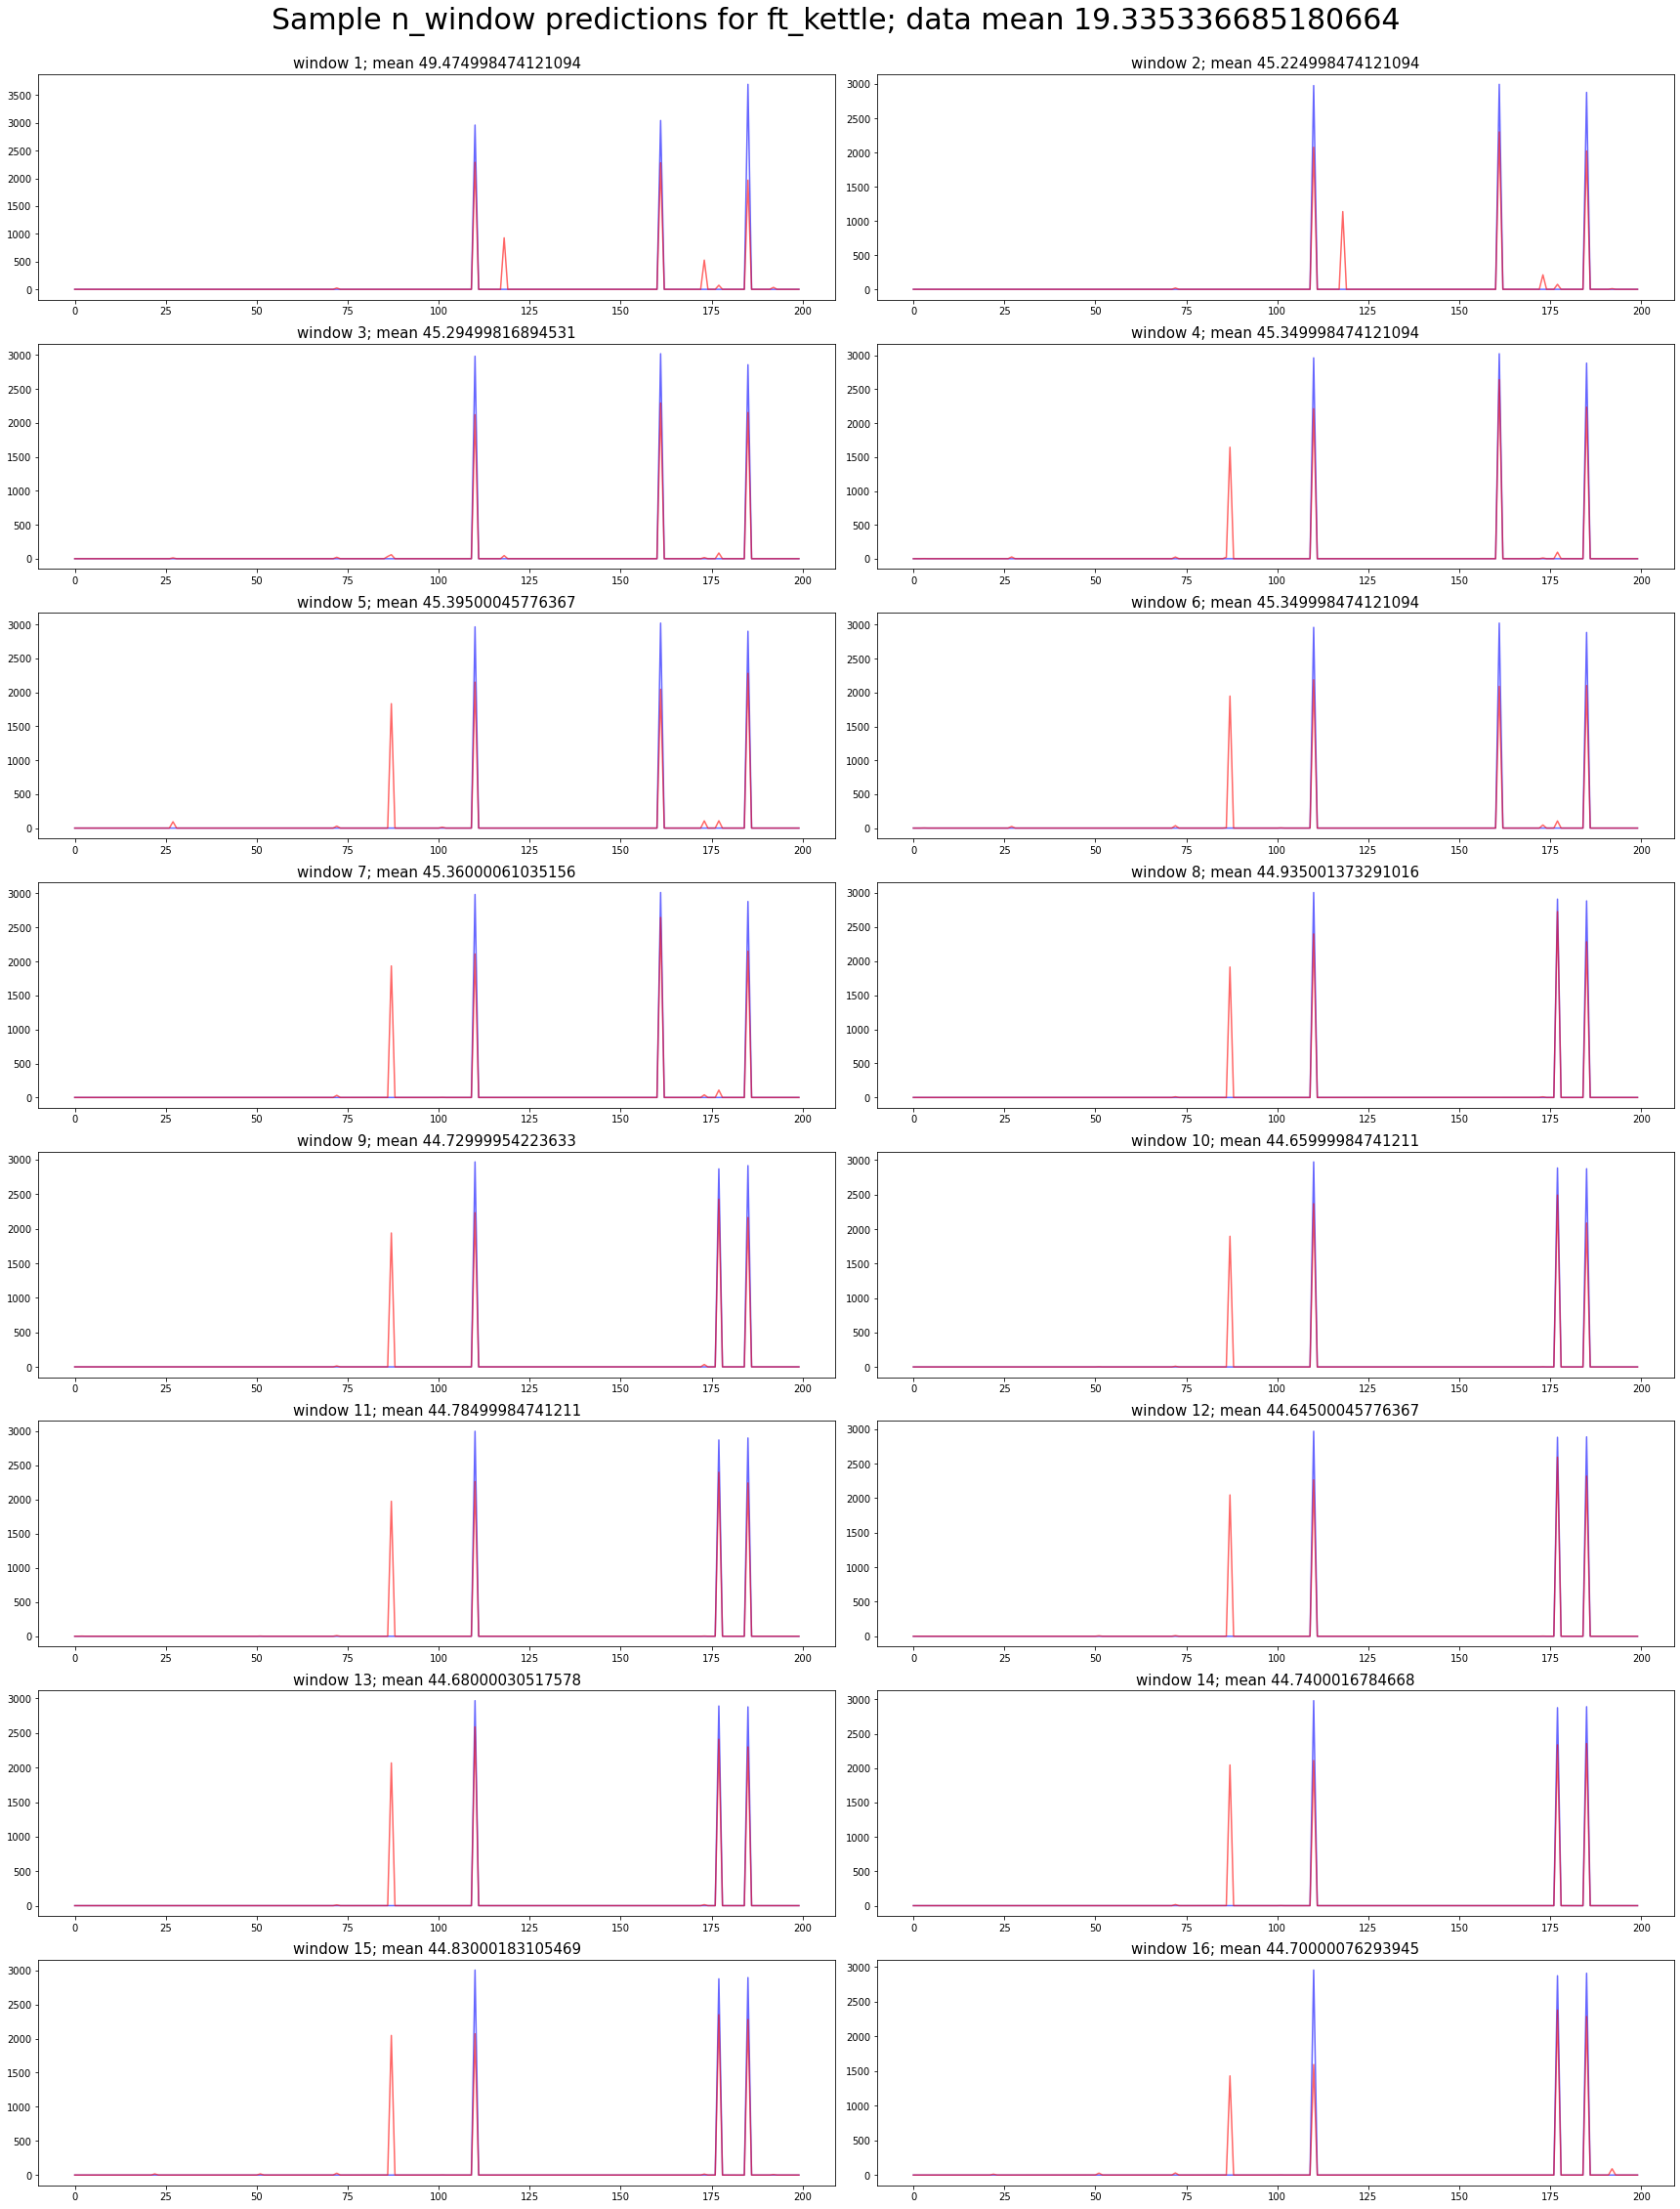

In [ ]:
n_samples = 200
plot_prediction_windows(FEATURE, y_test, y_pred, use_active=True, n_samples=n_samples)

In [ ]:
from lib import analysis

In [ ]:
results = analysis.classification_results(y_test, y_pred, on_threshold = 100)

metrics = {}
metrics["mae"] = analysis.mse_loss(y_test, y_pred)
metrics["mse"] = analysis.mae_loss(y_test, y_pred)
metrics["f1"] = analysis.f1(results)
metrics["accuracy"] = analysis.accuracy(results)
metrics["precision"] = analysis.precision(results)
metrics["recall"] = analysis.recall(results)

In [ ]:
print(metrics)

{'mae': 14778.53332127821, 'mse': 12.136192037170867, 'f1': 0.658669574700109, 'accuracy': 0.9934813734933486, 'precision': 0.49185667752442996, 'recall': 0.9966996699669967}


In [ ]:
results = analysis.classification_results(y_test, y_pred, on_threshold = 50)

metrics = {}
metrics["mae"] = analysis.mse_loss(y_test, y_pred)
metrics["mse"] = analysis.mae_loss(y_test, y_pred)
metrics["f1"] = analysis.f1(results)
metrics["accuracy"] = analysis.accuracy(results)
metrics["precision"] = analysis.precision(results)
metrics["recall"] = analysis.recall(results)
print(metrics)

{'mae': 14778.53332127821, 'mse': 12.136192037170867, 'f1': 0.5146996165317428, 'accuracy': 0.9881394319631375, 'precision': 0.3469270534175761, 'recall': 0.9966996699669967}


In [ ]:
results = analysis.classification_results(y_test, y_pred, on_threshold = 10)

metrics = {}
metrics["mae"] = analysis.mse_loss(y_test, y_pred)
metrics["mse"] = analysis.mae_loss(y_test, y_pred)
metrics["f1"] = analysis.f1(results)
metrics["accuracy"] = analysis.accuracy(results)
metrics["precision"] = analysis.precision(results)
metrics["recall"] = analysis.recall(results)
print(metrics)

{'mae': 14778.53332127821, 'mse': 12.136192037170867, 'f1': 0.38012891054865594, 'accuracy': 0.9794704917606019, 'precision': 0.23484848484848486, 'recall': 0.9967023907666942}
